In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

The IMDB movie reviews dataset comes packaged in `tfds`. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteK3AL5O/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteK3AL5O/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteK3AL5O/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_examples_batch, train_labels_batch = next(iter(train_dataset))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975], shape=(163,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


### Text Encoding
The dataset info includes the encoder (a `tfds.features.text.SubwordTextEncoder`).
This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [4]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
assert original_string == sample_string
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


Create batches of training data for your model. The reviews are all different lengths, so use `padded_batch` to zero pad the sequences while batching.

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

**Build Model with an LSTM layer**

Creating a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense layer`.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.
Keras sequential model here since all the layers in the model only have single input and produce single output.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the `binary_crossentropy` loss function. It is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [9]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

Train the model for 10 `epochs`. This is 10 iterations over all samples in the `train_dataset` tensors. 

In [10]:
history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 817s 2s/step - loss: 0.6397 - accuracy: 0.5734 - val_loss: 0.4733 - val_accuracy: 0.7583
Epoch 2/10
391/391 [==============================] - 867s 2s/step - loss: 0.3491 - accuracy: 0.8550 - val_loss: 0.3466 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 859s 2s/step - loss: 0.2509 - accuracy: 0.9049 - val_loss: 0.3324 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 861s 2s/step - loss: 0.2078 - accuracy: 0.9238 - val_loss: 0.3156 - val_accuracy: 0.8719
Epoch 5/10
391/391 [==============================] - 862s 2s/step - loss: 0.1843 - accuracy: 0.9340 - val_loss: 0.3475 - val_accuracy: 0.8729
Epoch 6/10
391/391 [==============================] - 863s 2s/step - loss: 0.1591 - accuracy: 0.9442 - val_loss: 0.3376 - val_accuracy: 0.8661
Epoch 7/10
391/391 [==============================] - 863s 2s/step - loss: 0.1521 - accuracy: 0.9474 - val_loss: 0.3604 - val_accuracy: 0.8536

**Test For Accuracy**

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 183s 468ms/step - loss: 0.4283 - accuracy: 0.8550
Test Loss: 0.4282757043838501
Test Accuracy: 0.854960024356842


Prediction Functions

In [12]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [13]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)
  
  output = ""
  if predictions[0][0] >= 0.5: output = "POSITIVE"
  elif predictions[0][0] <= -1: output = "NEGATIVE"
  else: output = "NEUTRAL"

  return output

**Prediction with Sample Sentiments**

In [14]:
sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-1.2465143]]
NEGATIVE


In [15]:
sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.11379167]]
NEUTRAL


In [16]:
sample_pred_text = ('This movie is awesome. The acting was incredicable. Highly recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[1.4532732]]
POSITIVE


In [17]:
sample_pred_text = ('This movie was so so. The acting was medicore. Kind of recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-0.49171886]]
NEUTRAL


In [18]:
# AVENGERS: ENDGAME 5 STAR COMMENT

sample_pred_text = ("""I loved the movie a lot as I am great fan of marvel! Avengers: Endgame, which marks the end of the Infinity Saga, is spellbounding 
and surely an enthralling experience. The last film of the 'Avengers' franchise is remarkable and doesn't disappoint. Watching all our favourite superheroes 
in one film is just surpassing. Marvel has been working on this grand culmination ever since they released 'Iron Man'. I'm damn sure that all of their hard 
work and ambition has paid off. The directors, Anthony and Joe Russo, have made sure that it delivers an unforgettable experience. Christopher Markus and 
Stephen McFeely have come up with a screenplay full of epic and unpredictable moments. The film has a great balance of humour, emotions and action. 
The biggest strength of the film is the emotions. This is the most emotional superhero film I have ever seen. It's just perfect. The action sequences 
were jaw-dropping. The climatic battle left me amazed. It's just filled with memorable moments and cannot be described with words. The visuals are gorgeous 
and have a great impact on the film. The humour doesn't look exaggerated and manages to entertain throughout the film. The plot twists were very impressive 
and suspenseful. The film features many cameos of characters from the previous MCU films, which just gives a double dose of excitement. The background score 
gives me goosebumps, though I've listened to it several times. It was really clever to make changes to the characterization of the Hulk. I enjoyed that a lot. 
But the show-stealer is Robert Downey Jr, who plays the role of Tony Stark/Iron Man. The man who started it all proves yet again that there's no one else who 
can perfect his role. Do not miss his powerful moments in the final battle.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[7.5766687]]
POSITIVE


In [19]:
# AVENGERS: ENDGAME 3 STAR COMMENT

sample_pred_text = ("""Overrated Sequel, But Still Good, But Violent! Beloved characters die, a character gets their head cut off, someone falls off a cliff, 
stabbings, punching, shooting, and more. The characters swear a bit. Even Captain America does! Role models include, Captain America, Iron Man, Hulk, AntMan, 
Black Widow, Hawkeye. Thor not so much because he SPOILER ALERT: got fat and played Fortnite the entire 5 year period. He was funny, but you may not want your 
kid wanting to say 'I want to be like the God of Thunder and play fortnite all day'. Characters did kiss. Thor drank a lot of beer. Captain America proved 
himself of something but not saying what. With reviewing the movie, the first half hour was good, then the next half hour was slow. The second half hour was 
pretty good, but the last hour was epic. From just starting out with Iron Man, Cap, Thor, and Hulk, to this amazing fight scene at the end, Avengers Endgame 
really pulled it off. Overall, pretty good for families and a good finale for the Infinity Saga.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-3.3150415]]
NEGATIVE


In [20]:
# AVENGERS: ENDGAME 3 STAR COMMENT

sample_pred_text = ("""I don't get why so many people like this movie so much, all they did was go back in time, so it didn't add much to the story. 
They also just added a whole bunch of scenes of previous marvel movies, and that is how they were able to make the movie three hours long. 
Now, getting to the inappropiate content for the parents. This is just your average superhero movie with sci-fi violence and some language. 
There are also strong roll models, but if you have a kid that is in elementary school or higher, you should let them watch this movie if they want to. 
But, I am not trying to parent your child, I am just giving my personal opinion, so you can choose to let them watch it, or you can prevent them from 
watching it.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-2.6585133]]
NEGATIVE


In [21]:
# AVENGERS: ENDGAME 1 STAR COMMENT

sample_pred_text = ("""Disappointing storyline - too many sad crying scenes - too much shit swearing compared to other great Marvel movies! Even as 
an adult I don't appreciate swearing in movies. There are MANY people who don't use cuss words in their lives except maybe in adrenaline traffic moments. 
To hear Robert Downey jr's 'moment' with his young child using and laughing at the fact that she uses 'adult' language is teaching the new impressionable 
ages watching this, that it is okay when it isn't. They seemed to want to use their cuss word quota for the rating for this movie. Sad writing when that's 
how they get their best laughs from audience. Bring back your creative, quirky writers from the two The Defenders of the Galaxy. Now that's smart character 
development and writing without resorting to desperate shock value. We have loved every movie of that series and eagerly await the next one. The Storyline 
was soooo boring in this. All of us watching kept hoping it would improve and it didn't. I think the only real laugh we had was the encounter on the ship 
between Quill (StarLord) and Thor. Subtle, but funny. We all could've cared less if anyone died. That's how checked out we were watching this LONG 3 HRS!!! 
Why! It was torture and I felt robbed of my time in the end.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-2.4277794]]
NEGATIVE


In [22]:
# AVENGERS ENDGAME COMMENT

sample_pred_text = ("""What a great way to end several major storylines that they invested in over the past 11 years. For people who have watched the saga, 
I feel like this is just the cherry on the top. My only complaint is something that you can't really get away from in superhero stories: the character 
'powers' are totally inconsistent from scene to scene, and movie to movie. This is a trope that there's no getting away from, because if characters like 
Captain Marvel, Thor, Scarlet Witch, and Hulk were always as powerful as they show flashes of, then the story wouldn't even be a thing. Any one of them 
could destroy Thanos in the blink of an eye, and have done similar feats in other stories (and even in other scenes within a given story). That they 
sometimes 'reduce' their power to a lower level, without an explained mechanism, is pretty laughable, and makes some parts of the story a bit nonsensical. 
Yes, this constant Ex Machina is needed to maintain the drama and keep the plot going, but it's still something that takes me out of the story.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[3.6573927]]
POSITIVE


In [23]:
sample_pred_text = ("""Superhero comics, and much of their adaptations, have long taken an outsized, soap opera-like approach to storytelling. 
At their best, they can take these fantastical ideas and make them emotionally resonant, even if there’s obviously no real-world phenomenon to connect them to. 
In some respects, Endgame pulls this off beautifully, like how the character Nebula confronts her past self through time travel, giving physical form to 
her personal growth. But as fun as the movie is, there’s an undeniable hollowness at its core induced by its unwillingness to follow through on certain 
ideas and symbols.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[1.5968482]]
POSITIVE


In [24]:
# AUGUST to JUNE: Bringing Life to School (http://augusttojune.com/press-media/audience-comments/)

sample_pred_text = ("""The film's ever-present focus on the 'big picture' of education and life! was much appreciated here and provided lots of talking points. 
In particular, we really liked seeing how you conferenced with parents, e.g., paraphrased:  'In a few more years, none of you will even remember who the early 
readers and late readers were', the overall approach to literacy- holistically focused rather than merely skills-focused, the ample time you provided to social 
growth/experiences/conflict resolution, and the fact that you did not choose to hide those moments where you, as a teacher, needed to separate or redirect 
children when disruptive.  There is a whole, whole, whole lot more that I wish to say! It is sad to know that this marked your retirement, but very 
heart-warming to know that your school carries on.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[1.7408558]]
POSITIVE


In [25]:
# AUGUST to JUNE: Bringing Life to School

sample_pred_text = ("""After we screened August To June, Boynton, Boca Democratic Party Movie Night presenters said in all their years of doing this had 
they never seen an audience response so serene. People wanted to stay. No one was angry. Conversations that never occurred did so after this viewing. People 
who had known each other for years discovered commonalities that previously they did not know existed. When this was shared I asked for any theories. 
The response, in unison, August To June is warm.  It touches people. Real life school situations gave the audience hope not only for what could be, but 
already is. People were reminded of good times and the challenges that helped them grow greater. As a Teacher, Amy taught as I think wise to live. Reciprocal 
reverence.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[4.970427]]
POSITIVE


Plotting Acuracy & Loss Function Graphs

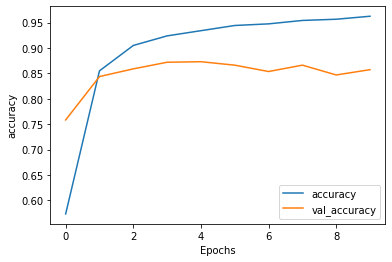

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy')

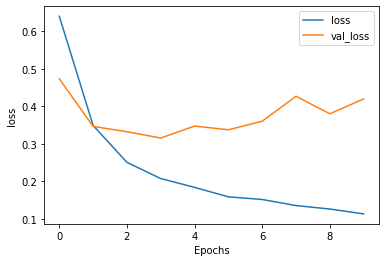

In [27]:
plot_graphs(history, 'loss')